In [75]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tqdm
import h5py
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
import skimage.transform as st
import skimage.filters as sf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [76]:
# Select global values for the normalisation
min_value = 0.01
max_value = 0.90
npix = 192

In [77]:
# Gaussian smoothing of binned images
sigma_gauss = 0.0

# These give the lower and upper cut values for each map
min_feature = np.array([5.5,5.5,4.0,-0.5,-10.0,2.5])
max_feature = np.array([9.5,8.5,7.5,1.14,-1.5,6.5])
cut_feature = 10.**np.array([5.5,5.5,4.0,-0.5,-10.0,2.5])
min_feature[3] = 10.**min_feature[3]
max_feature[3] = 10.**max_feature[3]
min_feature[4] = 10.**min_feature[4]
max_feature[4] = 10.**max_feature[4]

In [78]:
max_label = -15.5
min_label = -21.5

# First the features

In [79]:
# Load file for features
image_file = h5py.File('C:/Users/simin/Documents/studium/Thesis/images_intrinsic_binned.h5','r')

# Get all systems (galaxies) in this file
system_names = list(image_file.keys())
print(f'System Names = {system_names}\n')


        
map_names = image_file[list(image_file.keys())[0]][list(image_file[list(image_file.keys())[0]].keys())[0]].attrs['Maps']
nmaps = len(map_names)

X = np.empty((0, npix, npix, nmaps))

for system_name in system_names:
    system = image_file[system_name]
    projection_names = list(system.keys())
    for projection_name in projection_names:
        # Get full image
        full_image = np.array(system[projection_name])
        # Clip the image values
        for i in range(nmaps): full_image[:,:,i] = np.where(full_image[:,:,i] < cut_feature[i], cut_feature[i], full_image[:,:,i])
        # Get log surface density
        full_image[:,:,0] = np.log10(full_image[:,:,0])
        full_image[:,:,1] = np.log10(full_image[:,:,1])
        full_image[:,:,2] = np.log10(full_image[:,:,2])
        full_image[:,:,5] = np.log10(full_image[:,:,5])
        # Normalize and Clip
        full_image = (full_image - min_feature) / (max_feature - min_feature) * (max_value - min_value) + min_value 
        full_image[full_image < min_value] = min_value
        full_image[full_image > max_value] = max_value
        # Resize
        full_image = st.resize(full_image,(npix,npix),order=3,anti_aliasing=True,preserve_range=True)
        # Combine
        X = np.concatenate([X, full_image.reshape(1, npix, npix, nmaps)], axis=0)
            

X = np.transpose(X, (0,2,1,3)).astype(np.float32)
print(X.shape, X.min(), X.max, X.mean)

image_file.close()

System Names = ['g1.08e11', 'g1.12e12', 'g1.37e11', 'g1.52e11', 'g1.59e11', 'g1.77e12', 'g1.92e12', 'g2.41e11', 'g2.42e11', 'g2.57e11', 'g2.79e12', 'g3.06e11', 'g3.49e11', 'g5.38e11', 'g6.96e11', 'g7.08e11', 'g7.55e11', 'g7.66e11', 'g8.13e11', 'g8.26e11']

(219, 192, 192, 6) 0.01 <built-in method max of numpy.ndarray object at 0x0000026132C3C1C0> <built-in method mean of numpy.ndarray object at 0x0000026132C3C1C0>


# And now the labels

In [80]:
# Load file for labels
image_file = h5py.File('C:/Users/simin/Documents/studium/Thesis/images_withdust_AB.h5','r')

# Get all systems (galaxies) in this file
system_names = list(image_file.keys())
print(f'System Names = {system_names}\n')


filter_names = image_file[list(image_file.keys())[0]][list(image_file[list(image_file.keys())[0]].keys())[0]].attrs['Filters']
nfilters = len(filter_names)

y = np.empty((0, npix, npix, nfilters))

for system_name in system_names:
    system = image_file[system_name]
    projection_names = list(system.keys())
    for projection_name in projection_names:
        # Get full image
        full_image = np.array(system[projection_name])
        # Clip the image values
        full_image = np.where(full_image < 10.**min_label, 10.**min_label, full_image)
        # Get log surface density
        full_image = np.log10(full_image)
        # Normalize and clip
        full_image = (full_image - min_label) / (max_label - min_label) * (max_value - min_value) + min_value 
        full_image[full_image < min_value] = min_value
        full_image[full_image > max_value] = max_value
        # Resize
        full_image = st.resize(full_image,(npix,npix),order=3,anti_aliasing=True,preserve_range=True)
        # Combine
        y = np.concatenate([y, full_image.reshape(1, npix, npix, nfilters)], axis=0)
              

y = np.transpose(y, (0,2,1,3)).astype(np.float32)
print(y.shape, y.min(), y.max, y.mean)

image_file.close()

System Names = ['g1.08e11', 'g1.12e12', 'g1.37e11', 'g1.52e11', 'g1.59e11', 'g1.77e12', 'g1.92e12', 'g2.41e11', 'g2.42e11', 'g2.57e11', 'g2.79e12', 'g3.06e11', 'g3.49e11', 'g5.38e11', 'g6.96e11', 'g7.08e11', 'g7.55e11', 'g7.66e11', 'g8.13e11', 'g8.26e11']

(219, 192, 192, 5) 0.01 <built-in method max of numpy.ndarray object at 0x0000026132C3C800> <built-in method mean of numpy.ndarray object at 0x0000026132C3C800>


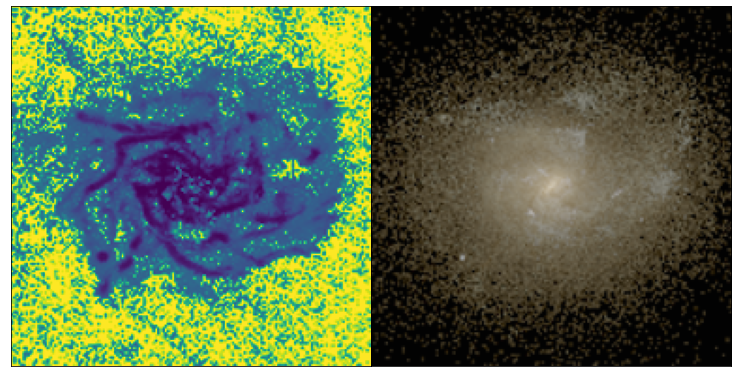

In [81]:
nr = 177
mm = 5

plt.figure(figsize=(10,20))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

ax1.imshow(X[nr,:,:,mm], vmin=min_value, vmax=max_value)
ax2.imshow(np.transpose(y[nr],(0,1,2))[:,:,[2,1,0]], vmin=min_value, vmax=max_value)

for ax in [ax1,ax2]:
    ax.tick_params(labelleft=False, labelbottom=False, labeltop=False, labelright=False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0, hspace=0.0, wspace=0.0)

# building U-Net Model

In [82]:
width = 192
height = 192
channels = 6

In [83]:
inputs = tf.keras.layers.Input((width, height, channels))

In [84]:
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Encoding path
#number one

c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.2)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c5)


In [85]:
# Decoding path
#number one

u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(1, 1), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c5])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c4])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c3])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c2])
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c1])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

In [86]:
outputs = tf.keras.layers.Conv2D(5, (3,3), activation='sigmoid', padding='same')(c10)

In [87]:
print('Inputs shape: ', inputs.shape)
print('Output shape: ', outputs.shape)

Inputs shape:  (None, 192, 192, 6)
Output shape:  (None, 192, 192, 5)


In [88]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='MSE')
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 192, 192, 6) 0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 192, 192, 6)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, 192, 192, 32) 1760        lambda_7[0][0]                   
__________________________________________________________________________________________________
dropout_72 (Dropout)            (None, 192, 192, 32) 0           conv2d_151[0][0]                 
______________________________________________________________________________________

In [89]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [90]:
results = model.fit(X,y, validation_split=0.2, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
11/11 [==============================] - 59s 5s/step - loss: 0.0786 - val_loss: 0.0410
Epoch 2/25
11/11 [==============================] - 57s 5s/step - loss: 0.0500 - val_loss: 0.0410
Epoch 3/25
11/11 [==============================] - 57s 5s/step - loss: 0.0500 - val_loss: 0.0410


In [68]:
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Encoding path
#number two

c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c4)

#c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#c5 = tf.keras.layers.Dropout(0.2)(c5)
#c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
#p5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c5)


In [69]:
# Decoding path
#number two

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(1, 1), padding='same')(c4)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [70]:
outputs = tf.keras.layers.Conv2D(5, (3,3), activation='sigmoid', padding='same')(c9)

In [71]:
print('Inputs shape: ', inputs.shape)
print('Output shape: ', outputs.shape)

Inputs shape:  (None, 192, 192, 6)
Output shape:  (None, 192, 192, 5)


In [72]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='MSE')
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 192, 192, 6) 0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 192, 192, 6)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 192, 192, 32) 1760        lambda_6[0][0]                   
__________________________________________________________________________________________________
dropout_64 (Dropout)            (None, 192, 192, 32) 0           conv2d_134[0][0]                 
______________________________________________________________________________________

In [73]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [74]:
results = model.fit(X,y, validation_split=0.2, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
11/11 [==============================] - 46s 4s/step - loss: 0.1057 - val_loss: 0.0385
Epoch 2/25
11/11 [==============================] - 48s 4s/step - loss: 0.0339 - val_loss: 0.0246
Epoch 3/25
11/11 [==============================] - 52s 5s/step - loss: 0.0209 - val_loss: 0.0396
Epoch 4/25
11/11 [==============================] - 52s 5s/step - loss: 0.0117 - val_loss: 0.0064
Epoch 5/25
11/11 [==============================] - 54s 5s/step - loss: 0.0067 - val_loss: 0.0056
Epoch 6/25
11/11 [==============================] - 57s 5s/step - loss: 0.0059 - val_loss: 0.0079
Epoch 7/25
11/11 [==============================] - 58s 5s/step - loss: 0.0055 - val_loss: 0.0050
Epoch 8/25
11/11 [==============================] - 60s 5s/step - loss: 0.0052 - val_loss: 0.0064
Epoch 9/25
11/11 [==============================] - 63s 6s/step - loss: 0.0048 - val_loss: 0.0132
